# Analisis de incertidumbre

Notebook para analizar algoritmos cuando se tiene incertidumbre en el tiempo de partida.

En primer lugar definimos el algoritmo a estudiar (por ahora EDF o LLF)

In [1]:
Algorithm = "LLF";

In [2]:
#using Pkg;Pkg.instantiate()
#import Pkg; Pkg.add("LaTeXStrings")
using EVQueues, Plots, Distributions, DataFrames, LaTeXStrings, KernelEstimator

┌ Info: Precompiling EVQueues [0ba0fc34-c32a-4e87-897a-dc4e812d5ecc]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling KernelEstimator [857edff2-01a9-55ba-8bc9-13e46c0ddbb2]
└ @ Base loading.jl:1278


Se definen los parámetros para realizar las simulaciones

In [4]:
#Incertidumbre (se modela como una Uniforme)
theta=1

#Parámetros del resto de la simulación
lambda=30.0;
mu=0.5;
gamma=0.25;
C=40.0;
Tfinal=200.0;

In [5]:
function threshold(theta,lambda,mu,C)
    rho = lambda/mu
    return -1/mu*log( (C/rho)*mu/theta/sinh(mu*theta))
end

threshold (generic function with 1 method)

El siguiente cuadro analiza resultados de vehiculos individualmente

In [6]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edf_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_llf_trace(df,C);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_llf_trace(df2,C);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

Simulando... 100%|██████████████████████████████████████| Time: 0:00:01


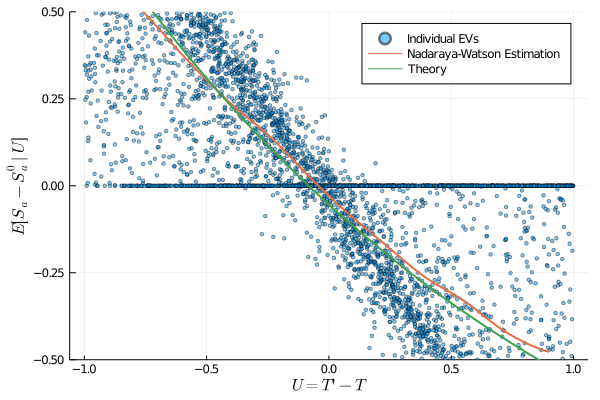

In [7]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;

tau = threshold(theta,lambda,mu,C)

Sa2_teo = exp.(-mu*tau)/mu*exp.(-mu*u)
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_alg, xeval=u);

scatter(diff_departure,Sa_alg_uncertain-Sa_alg,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson Estimation", ylims=(-.5,.5))
plot!(u,Sa2_teo.-Sa_teo,lw=2, label="Theory", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#savefig("MAMA1-LLF.pdf")

In [8]:
function llfc_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        deadlines = [ev.currentReportedDeadline for ev in evs];
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];

        positivas = findall(deadlines.>0)
        negativas = findall(deadlines.<=0)
        
        perm1 = sortperm(laxities[positivas]);
        perm2 = sortperm(laxities[negativas], rev=true);
        
        perm = [positivas[perm1];negativas[perm2]]
           
        p=0.0;
        i=1;
        U=zeros(length(evs));

        #recorro el vector en orden de deadline y le asigno su potencia maxima o lo que falte pare llegar a C (puede ser 0)
        while p<C && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C-p);
            p=p+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end

    end
    return U;
end

llfc_policy (generic function with 1 method)

Analisis con curtail

In [9]:
df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#Se corre el algoritmo "base", esto es, considerando los deadlines reales
if Algorithm == "EDF"
    alg = ev_edfc_trace(df,C);
    compute_statistics!(alg);
end

if Algorithm == "LLF"
    alg = ev_sim_trace(df,llfc_policy,C,[Inf]);
    compute_statistics!(alg);
end

#Se perturban las salidas, y se simula considerandola como la salida reportada
df2 = deepcopy(df)
df2[!,:salidaReportada] = df2[!,:salidas] + rand(Uniform(-theta,theta),nrow(df2))

if Algorithm == "EDF"
    alg_uncertain = ev_edfc_trace(df2,C);
    compute_statistics!(alg_uncertain);
end
    
if Algorithm == "LLF"
    alg_uncertain = ev_sim_trace(df2,llfc_policy,C,[Inf]);
    compute_statistics!(alg_uncertain);
end

alg_evs = sort(alg.EVs,by=ev->ev.arrivalTime)
alg_uncertain_evs = sort(alg_uncertain.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
alg_evs = alg_evs[n:end-n]
alg_uncertain_evs = alg_uncertain_evs[n:end-n]

#Guardo resultados de vehiculos
S_alg = [ev.requestedEnergy for ev in alg_evs];
S_alg_uncertain = [ev.requestedEnergy for ev in alg_uncertain_evs];

Sr_alg = [ev.departureWorkload for ev in alg_evs];
Sr_alg_uncertain = [ev.departureWorkload for ev in alg_uncertain_evs];

Sa_alg = S_alg - Sr_alg
Sa_alg_uncertain = S_alg_uncertain - Sr_alg_uncertain;

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


In [10]:
function threshold2(theta,lambda,mu,C)
    rho = lambda/mu
    ktheta = (1/2 + (1-exp(-mu*theta)/(2*mu*theta)))
    return -1/mu*log( C/rho*(1/ktheta))
end

threshold2 (generic function with 1 method)

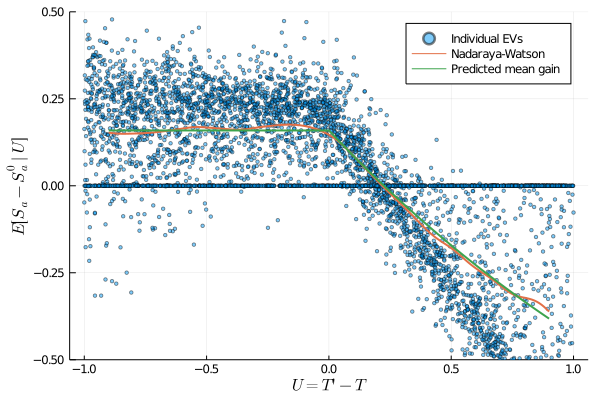

In [13]:
u=(-0.9*theta:0.01:0.9*theta)

alg_departure = [ev.reportedDepartureTime for ev in alg_evs];
alg_uncertain_departure = [ev.reportedDepartureTime for ev in alg_uncertain_evs];
diff_departure=alg_uncertain_departure - alg_departure;


tau2 = threshold2(theta,lambda,mu,C)
Sa3_teo = (exp.(-mu*(tau2.+max.(u,0))))/mu
Sa_teo = C/lambda

Sa_hat = localconstant(diff_departure, Sa_alg_uncertain - Sa_alg, xeval=u);

scatter(diff_departure,Sa_alg_uncertain-Sa_alg,alpha=0.5, label="Individual EVs", ms=2, ylims=(-.5,.5))
plot!(u,Sa_hat,lw=2, label="Nadaraya-Watson", ylims=(-.5,.5))
plot!(u,Sa3_teo.-Sa_teo,lw=2, label="Predicted mean gain", xlabel=L"U = T '-T", ylabel=L"E[S_a - S_a^0 \mid U]")
#savefig("MAMA2-LLF.pdf")